In [1]:
# general imports
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
import time
import numpy as np

# AWS imports: Import Braket SDK modules
from braket.circuits import Circuit, Observable
from braket.devices import LocalSimulator
from braket.aws import AwsDevice

In [4]:
# Check SDK version
!pip show amazon-braket-sdk 

^C


In [5]:
# Import Braket libraries
from braket.circuits import circuit, Circuit, Gate, Moments
from braket.circuits.instruction import Instruction
from braket.aws import AwsQuantumTask, AwsDevice
from braket.devices import LocalSimulator
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
import numpy as np

In [10]:
# Helper function to build C-C-Z gate
@circuit.subroutine(register=True)
def ccz(targets=[0, 1, 2]):
    """
    implementation of three-qubit gate CCZ
    """
    # define three-qubit CCZ gate
    ccz_gate = np.array([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                         [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                         [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                         [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
                         [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
                         [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
                         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0]],
                       dtype=complex)
    
    # instantiate circuit object
    circ = Circuit()
    
    # add CCZ gate
    circ.unitary(matrix=ccz_gate, targets=targets)
    
    return circ


# All possible items and their corresponding oracles
# define oracle dictionary using this CCZ gate

#not gates for flipping 0 to 1
oracle_sim = {"000": Circuit().x([0,1,2]).ccz(targets=[0, 1, 2]).x([0,1,2]),
              "001": Circuit().x([0,1]).ccz(targets=[0, 1, 2]).x([0,1]),
              "010": Circuit().x([0,2]).ccz(targets=[0, 1, 2]).x([0,2]),
              "011": Circuit().x([0]).ccz(targets=[0, 1, 2]).x([0]),
              "100": Circuit().x([1,2]).ccz(targets=[0, 1, 2]).x([1,2]),
              "101": Circuit().x([1]).ccz(targets=[0, 1, 2]).x([1]),
              "110": Circuit().x([2]).ccz(targets=[0, 1, 2]).x([2]),
              "111": Circuit().ccz(targets=[0, 1, 2])
          }


# helper function for initialization
def initialize(n_qubits=3):
    """
    function to apply hadamard to all qubits
    """
    # Initialize with superposition
    circ = Circuit();
    circ.h(np.arange(n_qubits))
    #print(circ)
    return circ


# helper function for phase oracle
def oracle(item):
    """
    function to apply oracle for given target item
    """
    # instantiate circuit object
    circ = Circuit()
    
    # add oracle
    circ.add_circuit(oracle_sim[item])
    
    return circ


# helper function for amplification
def amplify(n_qubits=3):
    """
    function for amplitude amplification
    """
    # instantiate circuit object
    circ = Circuit()
    
    # Amplification
    circ.h(np.arange(n_qubits))
    circ.add_circuit(oracle_sim['000'])
    circ.h(np.arange(n_qubits))
    
    return circ


# helper function for grover algorithm
def grover(item, n_qubits=3, n_reps=1):
    """
    function to put together individual modules of Grover algorithm
    """
    # initialize
    grover_circ = initialize()
    # oracle and amplify
    for ii in range(n_reps):
        # get oracle
        or_circ = oracle(item)
        grover_circ.add(or_circ)
        # amplify
        amplification = amplify()
        grover_circ.add(amplification)
    
    return grover_circ
        

In [11]:
def get_result(circ):
    
    # get number of qubits
    num_qubits = circ.qubit_count

    # specify desired results_types
    circ.probability()

    # submit task: define task (asynchronous)
    task = device.run(circ, shots=1000)

    # Get ID of submitted task
    task_id = task.id
#     print('Task ID :', task_id)

    # Wait for job to complete
    status_list = []
    status = task.state()
    status_list += [status]
    print('Status:', status)

    # Only notify the user when there's a status change
    while status != 'COMPLETED':
        status = task.state()
        if status != status_list[-1]:
            print('Status:', status)
        status_list += [status]

    # get result
    result = task.result()

    # get metadata
    metadata = result.task_metadata

    # get output probabilities
    probs_values = result.values[0]

    # get measurement results
    measurement_counts = result.measurement_counts

    # print measurement results
    print('measurement_counts:', measurement_counts)

    # bitstrings
    format_bitstring = '{0:0' + str(num_qubits) + 'b}'
    bitstring_keys = [format_bitstring.format(ii) for ii in range(2**num_qubits)]

    # plot probabalities
    plt.bar(bitstring_keys, probs_values);
    plt.xlabel('bitstrings');
    plt.ylabel('probability');
    plt.xticks(rotation=90);
    
    return measurement_counts

In [12]:
# set up the local simulator
device = LocalSimulator()

In [13]:
# get device name
device_name = device.name
# show the properties of the device 
device_properties = device.properties
# show supportedQuantumOperations (supported gates for a device)
device_operations = device_properties.dict()['action']['braket.ir.jaqcd.program']['supportedOperations']
# Note: This field also exists for other devices like the QPUs
print('Quantum Gates supported by {}:\n {}'.format(device_name, device_operations))

Quantum Gates supported by StateVectorSimulator:
 ['ccnot', 'cnot', 'cphaseshift', 'cphaseshift00', 'cphaseshift01', 'cphaseshift10', 'cswap', 'cv', 'cy', 'cz', 'ecr', 'h', 'i', 'iswap', 'pswap', 'phaseshift', 'rx', 'ry', 'rz', 's', 'si', 'swap', 't', 'ti', 'unitary', 'v', 'vi', 'x', 'xx', 'xy', 'y', 'yy', 'z', 'zz']


T  : |0|1|2|3|4|5|6|
                    
q0 : -H-U-H-X-U-X-H-
        |     |     
q1 : -H-U-H-X-U-X-H-
        |     |     
q2 : -H-U-H-X-U-X-H-

T  : |0|1|2|3|4|5|6|
Status: COMPLETED
measurement_counts: Counter({'111': 769, '110': 40, '100': 38, '010': 36, '001': 33, '101': 32, '000': 29, '011': 23})


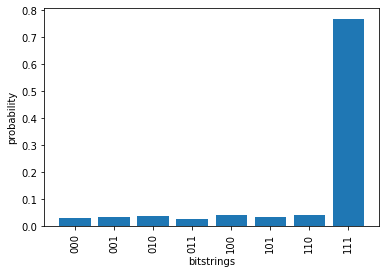

In [14]:
# Select item to find. Let's start with '111' for now
item = "111"

# get Grover circuit
circ = grover(item)

# print circuit
print(circ)

# Measurement
counts = get_result(circ)

T  : |0|1|2|3|4|5|6|7|8|
                        
q0 : -H---U-H-X---U-X-H-
          |       |     
q1 : -H-X-U-X-H-X-U-X-H-
          |       |     
q2 : -H-X-U-X-H-X-U-X-H-

T  : |0|1|2|3|4|5|6|7|8|
Status: COMPLETED
measurement_counts: Counter({'100': 776, '000': 45, '101': 33, '011': 32, '110': 30, '111': 28, '001': 28, '010': 28})


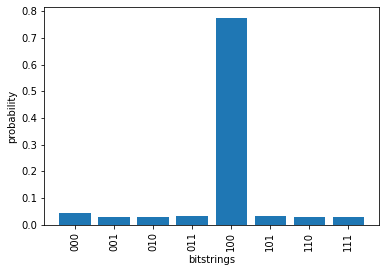

In [15]:
item = "100"

# get Grover circuit
circ = grover(item)

# print circuit
print(circ)

# Measurement
counts = get_result(circ)

T  : |0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|
                                               
q0 : -H---U-H-X---U-X-H---U--H--X-----U--X--H--
          |       |       |           |        
q1 : -H-X-U-X-H-X-U-X-H-X-U--X--H--X--U--X--H--
          |       |       |           |        
q2 : -H-X-U-X-H-X-U-X-H-X-U--X--H--X--U--X--H--

T  : |0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|
Status: COMPLETED
measurement_counts: Counter({'100': 947, '111': 9, '010': 9, '001': 8, '101': 7, '110': 7, '011': 7, '000': 6})


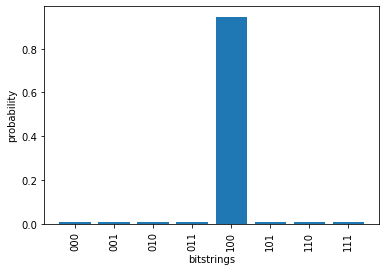

In [16]:
# Select item to find
item = "100"

# get Grover circuit
circ = grover(item, n_reps=2)

# print circuit
print(circ)

# Measurement
counts = get_result(circ)